In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.cluster import AffinityPropagation
import sklearn
from sklearn.preprocessing import StandardScaler
import imageio
from io import BytesIO

In [3]:
def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

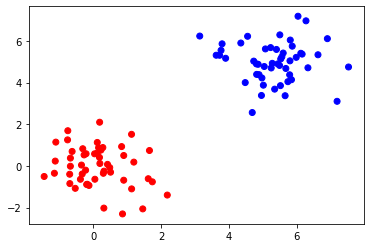

In [4]:
n = 50
size = (n, 2)
np.random.seed(1)
x = np.random.normal(0, 1, size)
x = np.append(x, np.random.normal(5, 1, size), axis=0)

c = ['r' for _ in range(n)] + ['b' for _ in range(n)]
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

In [5]:
def similarity(xi, xj):
    return -((xi - xj)**2).sum()

In [6]:
def create_matrices():
    S = np.zeros((x.shape[0], x.shape[0]))
    R = np.array(S)
    A = np.array(S)
    # when looking in row i, the value means you should compare to column i - value
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            S[i, j] = similarity(x[i], x[j])
            
    return A, R, S


$ r(i, k) \leftarrow s(i, k) - \max\limits_{k' s.t. k' \neq k}\{ a(i, k') + s(i, k') \}$

In [7]:
def update_r(lmda=0.9, slow=False):
    global R
    if slow:
        for i in range(x.shape[0]):
            for k in range(x.shape[0]):
                v = S[i, :] + A[i, :]
                v[k] = -np.inf
                v[i]= -np.inf
                R[i, k] = R[i, k] * lmda + (1 - lmda) * (S[i, k] - np.max(v))
    
    else:
        # For every column k, except for the column with the maximum value the max is the same.
        # So we can subtract the maximum for every row, and only need to do something different for k == argmax
        
        v = S + A
        rows = np.arange(x.shape[0])
        # We only compare the current point to all other points, so the diagonal can be filled with -infinity
        np.fill_diagonal(v, -np.inf)

        # max values
        idx_max = np.argmax(v, axis=1)
        first_max = v[rows, idx_max]

        # Second max values. For every column where k is the max value.
        v[rows, idx_max] = -np.inf
        second_max = v[rows, np.argmax(v, axis=1)]

        # Broadcast the maximum value per row over all the columns per row.
        max_matrix = np.zeros_like(R) + first_max[:, None]
        max_matrix[rows, idx_max] = second_max

        new_val = S - max_matrix

        R = R * lmda + (1 - lmda) * new_val

In [8]:
A, R, S = create_matrices()

%timeit update_r(slow=False)

49 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


$ a(i, k) \leftarrow \min\{0, r(k,k) + \sum\limits_{i' s.t. i' \notin \{i, k\}}{\max\{0, r(i', k)\}}$ 

$ a(k, k) \leftarrow \sum\limits_{i' \neq k}\max(0, r(i', k)) $

In [9]:
def update_a(lmda=0.9, slow=False):
    global A
    
    if slow:
        for i in range(x.shape[0]):
            for k in range(x.shape[0]):
                v = np.array(R[:, k])
                if i != k:
                    v[i] = -np.inf
                    v[k] = - np.inf
                    v[v < 0] = 0

                    A[i, k] = A[i, k] * lmda + (1 - lmda) * min(0, R[k, k] + v.sum())
                else:
                    v[k] = -np.inf
                    v[v < 0] = 0
                    A[k, k] = A[k, k] * lmda + (1 - lmda) * v.sum()
    else:
        k_k_idx = np.arange(x.shape[0])
        # set a(i, k)
        v = np.array(R)
        v[v < 0] = 0
        np.fill_diagonal(v, 0)
        v = v.sum(axis=0) # columnwise sum
        v = v + R[k_k_idx, k_k_idx]

        # broadcasting of columns 'r(k, k) + sum(max(0, r(i', k))) to rows.
        v = np.ones(A.shape) * v

        # For every column k, subtract the positive value of k. 
        # This value is included in the sum and shouldn't be
        v -= np.clip(R, 0, np.inf)
        v[v > 0] = 0
        
        # set(a(k, k))
        v_ = np.array(R)
        np.fill_diagonal(v_, 0)

        v_[v_ < 0] = 0

        v[k_k_idx, k_k_idx] = v_.sum(axis=0) # column wise sum
        A = A * lmda + (1 - lmda) * v

def plot_iteration(A, R):
    fig = plt.figure(figsize=(12, 6))
    sol = A + R
    
    labels = np.argmax(sol, axis=1)

    exemplars = np.unique(labels)
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = x[i][0]
        Y = x[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            plt.plot([X, x[exemplar][0]], [Y, x[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %s' % len(exemplars))
    return fig, labels, exemplars
    


In [10]:
np.median(S)

-18.604664796288205

CPU times: user 432 ms, sys: 10.4 ms, total: 442 ms
Wall time: 441 ms


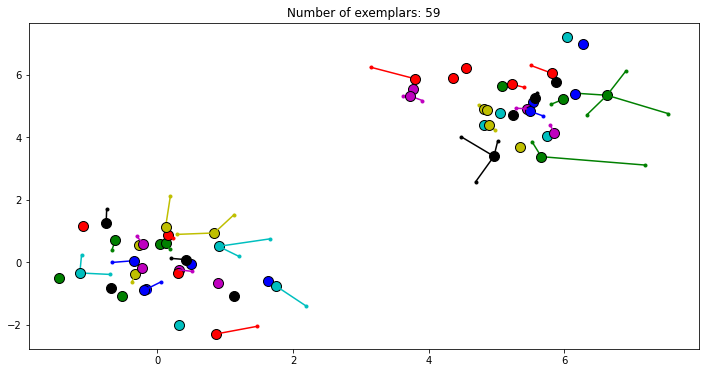

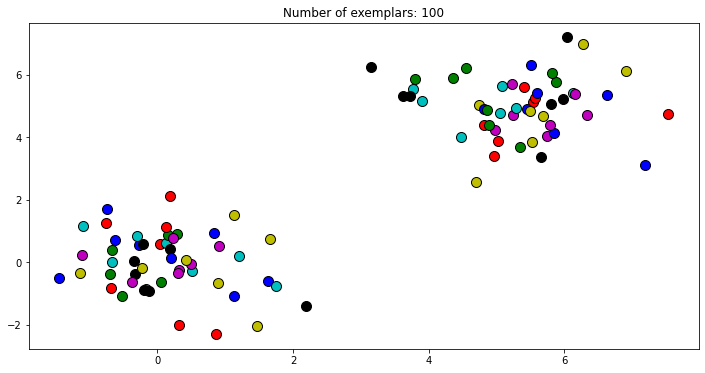

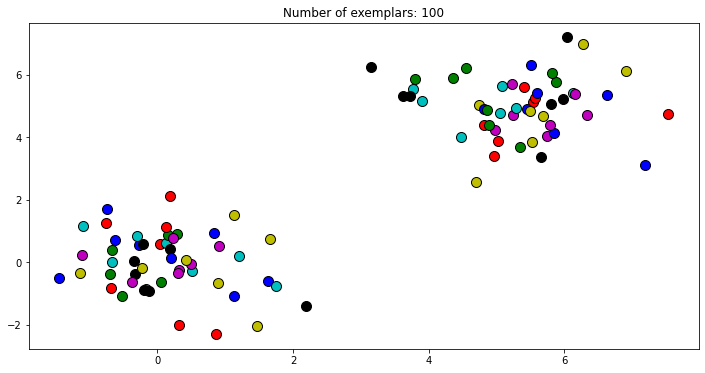

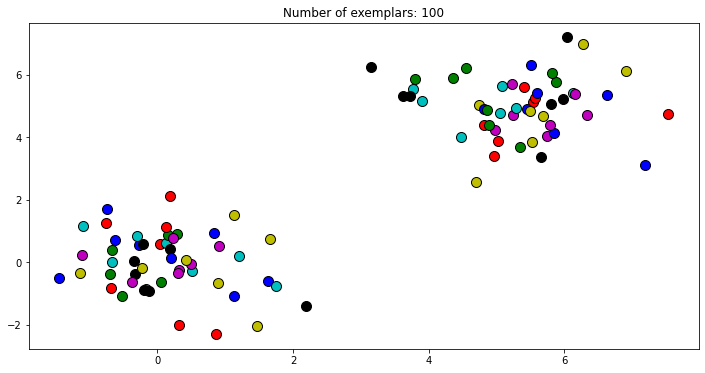

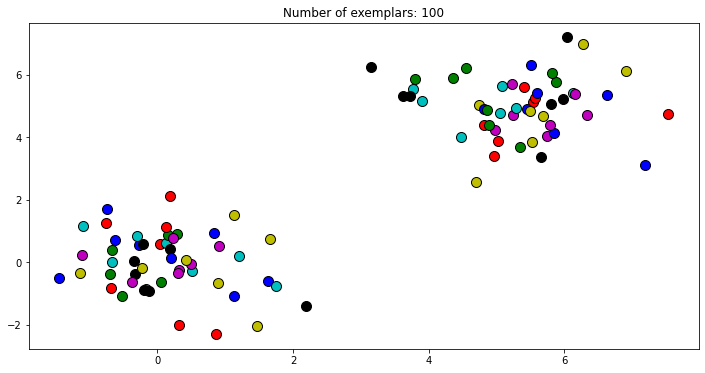

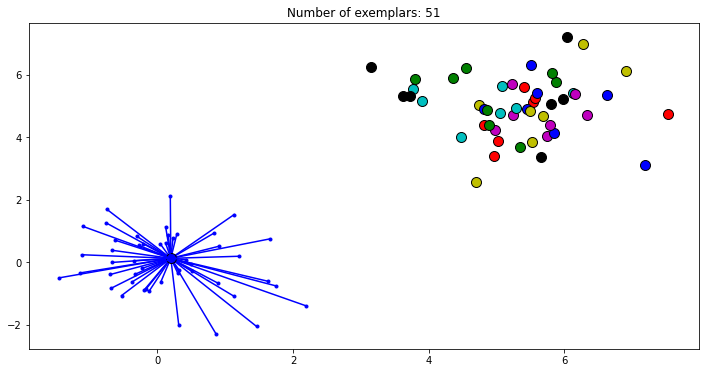

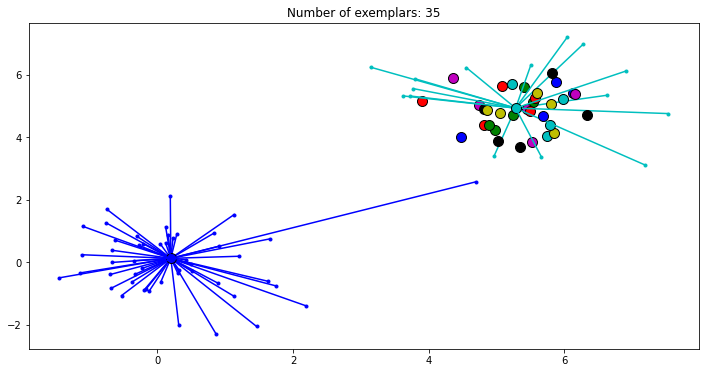

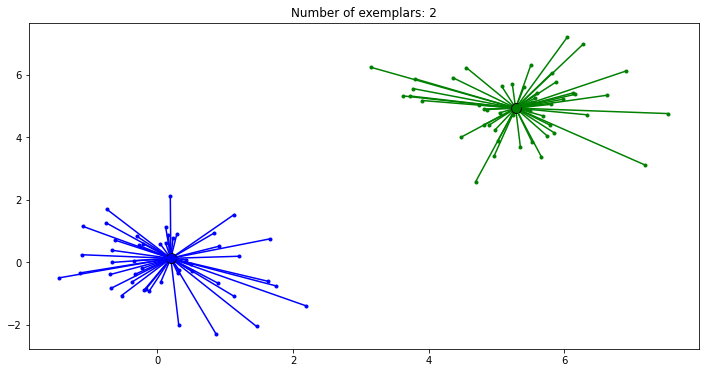

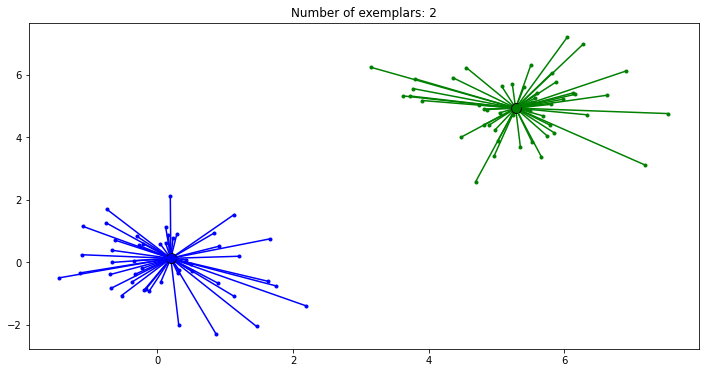

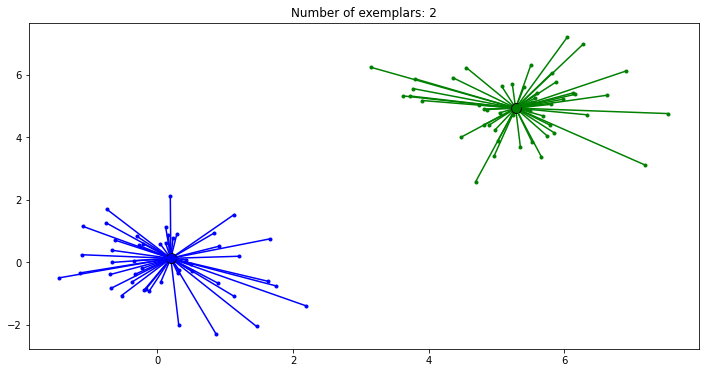

In [11]:
%%time
A, R, S = create_matrices()
preference = np.median(S)
preference =  -1000

np.fill_diagonal(S, preference)
damping = 0.5

figures = []
for i in range(50):
    update_r(damping)
    update_a(damping, 0)
    
    if i % 5 == 0:
        fig, labels, exemplars = plot_iteration(A, R)
        figures.append(fig)
    

In [12]:
make_gif(figures, 'test.gif', 2)